In [15]:
# импорт библиотек

# работа с директориями
from glob import glob # поиск файлов по шаблону
import os
import shutil

# визуализация данных
import matplotlib.pyplot as plt
import pandas as pd

# работа с изображениями
import PIL
from PIL import Image
import torchvision.models as models # модели для работы с изображениями
import torchvision.transforms as transforms # преобразование изображений

# для jupyter notebook
from tqdm.notebook import tqdm # прогресс-бар

# numpy
import numpy as np

# scikit-learn
from sklearn.model_selection import GroupKFold # кросс-валидация
from sklearn.metrics import roc_curve #
from sklearn import metrics #

# pytorch
import torch
import torch.nn as nn # разные слои
import torch.nn.functional as F # функции активации
import torch.nn.init as init # начальная инициализация весов в слоях
from torch.utils.data import Dataset # датасет поместим в объект dataset
from torch.utils.data import DataLoader # это объект разбиения на батчи
from torch.utils.data import random_split

# остальное
import itertools
import random
import time

# комментарии надо дописать

# 1. Постановка задачи

Будем обучать нейросеть, которая должна будет изображения перерисовывать в стиле картин Моне, это задача с kaggle.com - [ссылка](https://www.kaggle.com/competitions/gan-getting-started), данные для обучения скачал оттуда:

- `monet_jpg` - папка с 300 jpg-изображениями картин Моне размера 256x256
- `photo_jpg` - папка с 7038 jpg-изображениями размера 256x256
- `monet_tfrec` и `photo_jpg` - аналогично, но формата .tfrec - бинарное представление данных (их использовать не будем, это, как я понял, для библиотеки `TensorFlow`)

Использовать для этого будем библиотеку `PyTorch`, поэтому как итог раздела определим на чем будут производиться вычисления - библиотека поддерживает вычисления как на обычном процессоре, так и на графическом.

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 2. Импорт данных (предварительно упаковав их в интерфейс `Dataset` библиотеки `PyTorch`)

In [48]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256)):
        super().__init__()
        self.monet_dir = monet_dir # это путь к картинам Моне в формате .jpg
        self.photo_dir = photo_dir # это путь к обычным изображениям в том же формате
        self.monet_idx = dict()    # тут будут храниться имена файлов
        self.photo_idx = dict()    # аналогично
        self.transform = transforms.Compose([
            transforms.Resize(size), # приводим к определенному размеру
            transforms.ToTensor(),   # создаем из изображение PyTorch tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # каналы [0, 1] -> [-1, 1]                               
        ])
        # not f.startswith('.') для того чтобы исключить папку .ipynb_checkpoints
        for i, fl in enumerate([f for f in os.listdir(self.monet_dir) if not f.startswith('.')]):
            self.monet_idx[i] = fl
        for i, fl in enumerate([f for f in os.listdir(self.photo_dir) if not f.startswith('.')]):
            self.photo_idx[i] = fl

    def __getitem__(self, idx): # вместе с картиной Моне извлекаем случайное обычное изображение
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return monet_img, photo_img

    def __len__(self):
        return len(self.monet_idx.keys())

In [46]:
img_ds = ImageDataset('monet_jpg/', 'photo_jpg/')

Давайте посмотрим на примеры загруженных данных.

In [61]:
# это обратное преобразование [-1, 1] -> [0, 1] для визуализации (такие данные принимает plt.imshow)
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
    return img

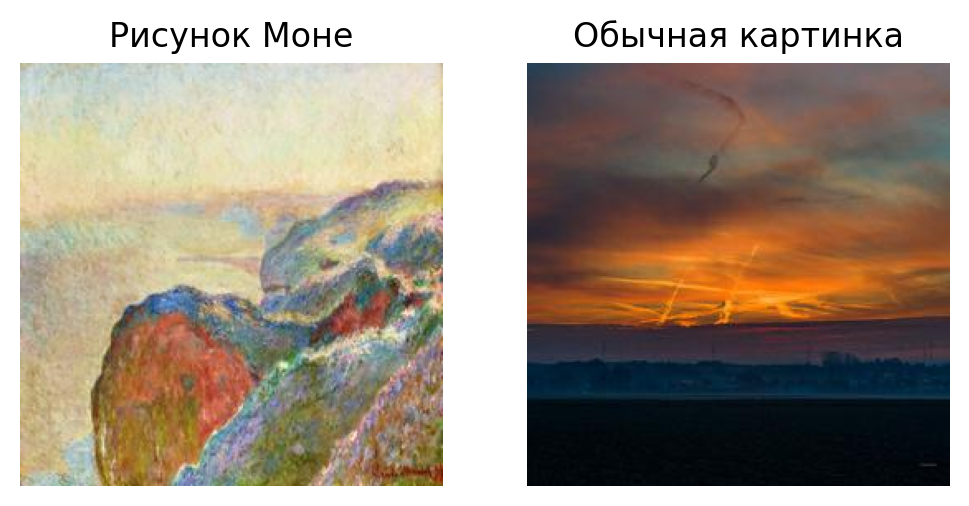

In [60]:
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True) # разбиение на батчи
monet_img, photo_img = next(iter(img_dl)) # извлекаю 1 батч

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), dpi=200)

ax[0].axis('off')
ax[0].set_title('Рисунок Моне')
monet_img = unnorm(monet_img)
ax[0].imshow(monet_img[0].permute(1, 2, 0)) # tensor имеет shape = (channel, width, height)
                                            # переводим его в shape = (width, height, channel) для .imshow
ax[1].axis('off')
ax[1].set_title('Обычная картинка')
photo_img = unnorm(photo_img)
ax[1].imshow(photo_img[0].permute(1, 2, 0));

# 3. Разработка модели

Решение задачи будет осуществляться с помощью нейросети `CycleGAN`.

**CycleGAN** (Cycle-Consistent Generative Adversarial Network) — это тип генеративной состязательной сети (GAN), предназначенный для выполнения непарного перевода изображений. В отличие от традиционных методов, которые требуют пар данных для обучения (например, пары изображений "до" и "после"), CycleGAN обучается на одном наборе изображений для каждой из двух доменов и может генерировать изображения одного домена в изображения другого домена без наличия парных данных.

In [2]:
# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.deconv1(x))
        x = self.tanh(self.deconv2(x))
        return x

In [3]:
# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.fc = nn.Linear(128 * 8 * 8, 1)

    def forward(self, x):
        x = self.leaky_relu1(self.conv1(x))
        x = self.leaky_relu2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [4]:
# Восстановление исходного изображения через циклическую консистентность
def cycle_consistency_loss(real_image, reconstructed_image):
    return nn.L1Loss()(reconstructed_image, real_image)

In [5]:
# Потери для GAN
def gan_loss(prediction, target_is_real=True):
    target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
    return nn.BCEWithLogitsLoss()(prediction, target)

In [6]:
# Определение оптимизаторов
generator_G = Generator().cuda()
generator_F = Generator().cuda()
discriminator_D_X = Discriminator().cuda()
discriminator_D_Y = Discriminator().cuda()

optimizer_G = optim.Adam(itertools.chain(generator_G.parameters(), generator_F.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = optim.Adam(discriminator_D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(discriminator_D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
print(torch.version.cuda)

11.8
